In [2]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import numpy as np

import networkx as nx


#### Loading taxi dataset

In [3]:
df2023 = pd.read_csv('combined.csv')
# df2023.info()

#### Loading zones dataset

In [4]:
zones = gpd.read_file("C:/Users/anape/nyc-taxi/taxi_zones/taxi_zones.shp")
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [5]:
df2023 = df2023.merge(
    right=zones[['LocationID', 'borough']], 
    left_on='pulocationid', 
    right_on='LocationID',
    suffixes=('_pu', '')
)
df2023.drop(columns=['LocationID'], inplace=True)

df2023 = df2023.merge(
    right=zones[['LocationID', 'borough']], 
    left_on='dolocationid', 
    right_on='LocationID',
    suffixes=('_do', '')
)
df2023.drop(columns=['LocationID'], inplace=True)

In [111]:
manhattan = df2023[(df2023['borough'] == 'Manhattan') & (df2023['borough_do'] == 'Manhattan')]


len(manhattan)/len(df2023)

0.8206601507270754

In [112]:
len(manhattan)

27423855

In [7]:
days = sorted(manhattan['dayofyear'].unique())
dataframes = manhattan.groupby('dayofyear')

In [107]:
daygraphs = {}

for i in days:
    G = nx.DiGraph()
    # dictionary to store edge counts which will be weights
    edge_counts = {}

    for idx, row in dataframes.get_group(i).iterrows():
        origin = row['pulocationid']
        destination = row['dolocationid']

        # add nodes if they don't exist
        G.add_node(origin, LocationID = origin)
        G.add_node(destination, LocationID = destination)

        # update edge count dictionary
        edge_key = (origin, destination)  # Key for edge (ordered pair)
        edge_counts[edge_key] = edge_counts.get(edge_key, 0) + 1
    
        # sort edges based on weight
    sorted_edges = sorted(edge_counts.items(), key=lambda x: x[1], reverse=True)

    # add edges with top 10 weights
    for edge, count in sorted_edges[:50]:
        G.add_edge(*edge, weight=count)

    G.remove_nodes_from(list(nx.isolates(G)))

    daygraphs[i] = G
    if i%20 == 0:
        print(f'Day {i} done')

Day 20 done
Day 40 done
Day 60 done
Day 80 done
Day 100 done
Day 120 done
Day 140 done
Day 160 done
Day 180 done
Day 200 done
Day 220 done
Day 240 done
Day 260 done
Day 280 done
Day 300 done
Day 320 done
Day 340 done
Day 360 done


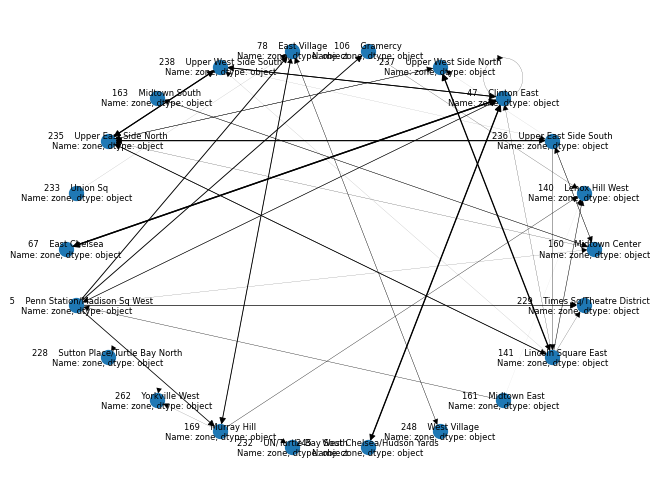

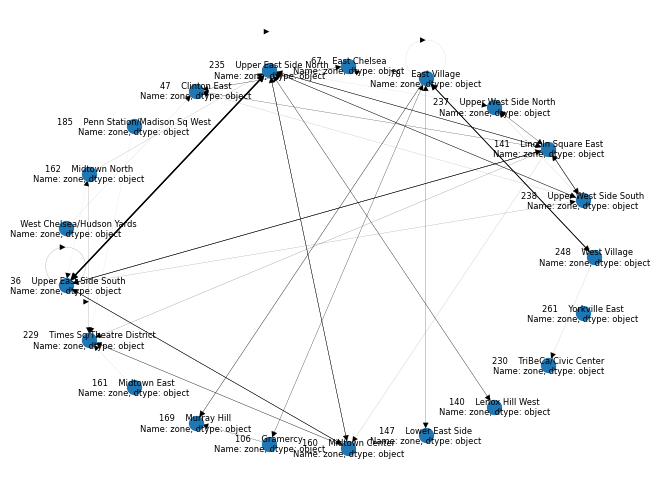

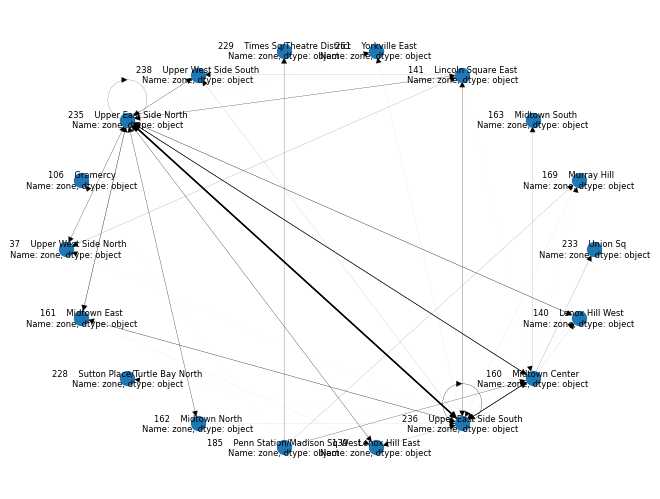

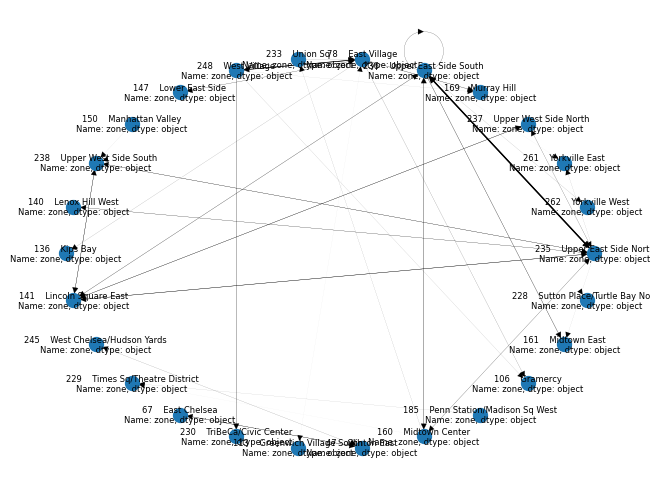

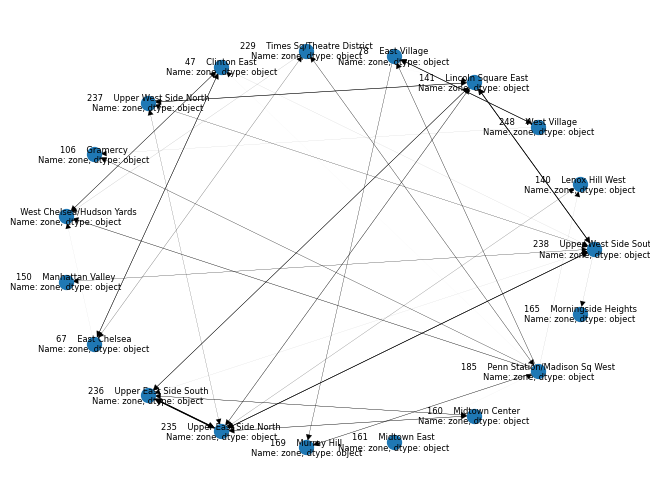

In [123]:
for a in [0, 118, 149, 258, 287]:
    net = list(daygraphs.values())[a]

    # circular layout for best visibility
    pos = nx.circular_layout(net)

    # mapping numeric labels to their names
    node_labels = {node: zones[zones['LocationID'] == node]['zone'] for node in net.nodes()}

    # normalizing edges weight to plot
    weights = [d['weight'] for u, v, d in net.edges(data=True)]
    max_weight = max(weights)
    min_weight = min(weights)
    normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in weights]

    # Draw the network
    nx.draw(net, pos = pos, labels = node_labels,
            node_size = 100, with_labels = True,
            font_size = 6, width = normalized_weights)
    
    plt.show()


In [125]:
from torch_geometric.utils.convert import from_networkx

G = daygraphs[1]
G_tensor = from_networkx(G, group_node_attrs = 'all')
G_tensor



Data(edge_index=[2, 50], weight=[50], x=[22, 1])